In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Montar Google Drive para acceder a los datos
# from google.colab import drive
# drive.mount('/content/drive')

# Ruta del dataset en Google Drive
# dataset = '//content/drive/MyDrive/Colab Notebooks/M15S19/imagenes'

In [3]:
# Ruta principal donde están las subcarpetas de las clases
dataset = r"C:\Users\Diego\Tarea UDD\Clase 3\imagenes"

## Analisis Exploratorio del dataset

In [4]:
import os

# Listar las carpetas de las clases
classes = os.listdir(dataset)
print(f"Clases detectadas: {classes}")

Clases detectadas: ['autos', 'aviones', 'camiones']


In [5]:
# Contar la cantidad de imágenes en cada clase
for class_name in classes:
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} imágenes")


autos: 20 imágenes
aviones: 20 imágenes
camiones: 20 imágenes


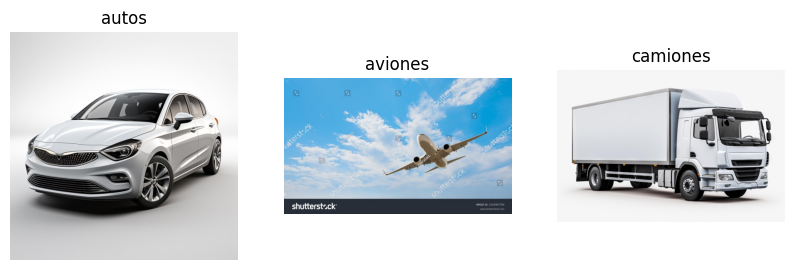

In [6]:
# Visualizamos una imagen por cada carpeta
from PIL import Image
import matplotlib.pyplot as plt

# Mostrar una imagen de cada clase
plt.figure(figsize=(10, 5))
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset, class_name)
    first_image_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(first_image_path)

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()


In [7]:
# Visualizamos las dimensiones, los canales, los bits y el formato de cada imagen 

from PIL import Image, UnidentifiedImageError
import os

# Extensiones soportadas, agrega si tienes otro formato distinto
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

# Inspeccionar cada imagen y extraer sus características
for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        print(f"\nClase: {class_name}")
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            # Verificar extensión del archivo
            if not os.path.splitext(img_path)[1].lower() in valid_extensions:
                print(f"Archivo no soportado (omitido): {img_name}")
                continue

            try:
                # Abrir y analizar la imagen
                with Image.open(img_path) as img:
                    dimensions = img.size  # (ancho, alto)
                    mode = img.mode  # Modo de color (e.g., RGB, L, etc.)
                    bits = img.bits if hasattr(img, 'bits') else 'Desconocido'  # Bits por canal
                    fmt = img.format  # Formato de la imagen
                    print(f"Imagen: {img_name} - Dimensiones: {dimensions}, Canales: {mode}, Bits: {bits}, Formato: {fmt}")
            except UnidentifiedImageError:
                print(f"Error: No se pudo identificar la imagen: {img_name}")



Clase: autos
Imagen: auto001.jpg - Dimensiones: (826, 826), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto002.jpg - Dimensiones: (1380, 789), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto003.jpg - Dimensiones: (1060, 795), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto004.jpg - Dimensiones: (1800, 900), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto005.jpg - Dimensiones: (1380, 920), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto006.jpg - Dimensiones: (1380, 920), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto007.jpg - Dimensiones: (996, 796), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto008.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto009.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto010.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto011.jpg - Dimensiones: (1380, 776), Canales: RGB, Bits: 8, Formato: JPEG
Imagen: auto012.jpg - Dimensiones: (1380, 776), Canal

## Creamos el modelo de red neuronal convolucional

In [9]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.optimizers.legacy import RMSprop
from sklearn.preprocessing import LabelEncoder

# Parámetros
img_height, img_width = 128, 128  # Ajustar tamaño de las imágenes
num_classes = 3  # Número de clases (ajustar según tu caso)
batch_size = 8
epochs = 50

# Cargar las imágenes
x_data = []
labels = []

for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize((img_width, img_height))
                    x_data.append(np.array(img))
                    labels.append(class_name)
            except Exception as e:
                print(f"Error al procesar la imagen {img_name}: {e}")

# Convertir las listas a arrays NumPy
x_data = np.array(x_data, dtype="float32") / 255.0  # Normalizar
labels = np.array(labels)

# Convertir etiquetas a formato one-hot encoding
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(labels)
y_data = to_categorical(y_data, num_classes=num_classes)

# Dividir los datos en entrenamiento y validación
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Cargar el modelo base preentrenado ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Loss en test: {test_loss}, Accuracy en test: {test_accuracy}")



Epoch 1/50


6/6 [==============================] - 4s 285ms/step - loss: 1.7515 - accuracy: 0.2083 - val_loss: 1.0067 - val_accuracy: 0.3333
Epoch 2/50
6/6 [==============================] - 1s 132ms/step - loss: 1.3435 - accuracy: 0.2917 - val_loss: 1.3948 - val_accuracy: 0.1667
Epoch 3/50
6/6 [==============================] - 1s 134ms/step - loss: 1.3143 - accuracy: 0.3750 - val_loss: 0.9916 - val_accuracy: 0.3333
Epoch 4/50
6/6 [==============================] - 1s 135ms/step - loss: 1.0592 - accuracy: 0.4375 - val_loss: 1.1497 - val_accuracy: 0.1667
Epoch 5/50
6/6 [==============================] - 1s 133ms/step - loss: 1.0542 - accuracy: 0.3958 - val_loss: 1.0654 - val_accuracy: 0.4167
Epoch 6/50
6/6 [==============================] - 1s 133ms/step - loss: 1.0802 - accuracy: 0.4583 - val_loss: 0.9515 - val_accuracy: 0.5000
Epoch 7/50
6/6 [==============================] - 1s 133ms/step - loss: 1.1041 - accuracy: 0.4167 - val_loss: 1.1215 - val_accuracy: 0.3333
Epoch 8/50
6/6 [==

## Visualizamos la funcion de perdida y la precision

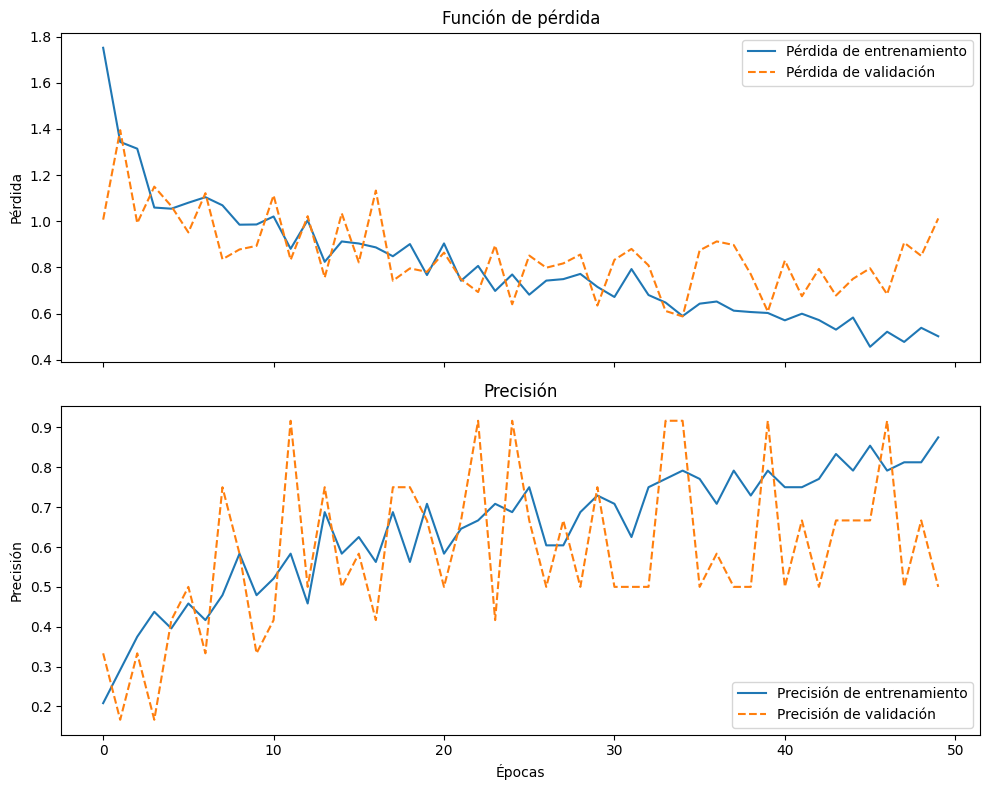

In [10]:
import matplotlib.pyplot as plt

# Crear figura
fig = plt.figure(figsize=(10, 8))

# Gráfico de la función de pérdida
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['loss'], label='Pérdida de entrenamiento')
ax1.plot(history.history['val_loss'], label='Pérdida de validación', linestyle='--')
ax1.set_title('Función de pérdida')
ax1.set_ylabel('Pérdida')
ax1.legend(loc='upper right')

# Gráfico de precisión
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax2.plot(history.history['accuracy'], label='Precisión de entrenamiento')
ax2.plot(history.history['val_accuracy'], label='Precisión de validación', linestyle='--')
ax2.set_title('Precisión')
ax2.set_ylabel('Precisión')
ax2.set_xlabel('Épocas')
ax2.legend(loc='lower right')

# Ocultar etiquetas de los ejes x del primer gráfico
plt.setp(ax1.get_xticklabels(), visible=False)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

## Matriz de confusion

1/1 [==============================] - 1s 731ms/step


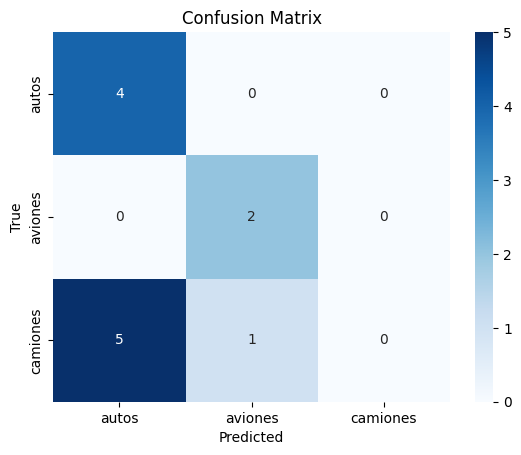

              precision    recall  f1-score   support

       autos       0.44      1.00      0.62         4
     aviones       0.67      1.00      0.80         2
    camiones       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.37      0.67      0.47        12
weighted avg       0.26      0.50      0.34        12



C:\Users\Diego\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diego\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diego\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones del modelo
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualización de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Métricas
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


## Guardamos el modelo para ocuparlo posteriormente

In [12]:
# Guardar el modelo en la ruta especificada
save_path = r"C:\Users\Diego\Tarea UDD\Clase 3\modelo_ResNet50.h5"
model.save(save_path)
print(f"Modelo guardado en: {save_path}")

C:\Users\Diego\anaconda3\envs\gpu\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado en: C:\Users\Diego\Tarea UDD\Clase 3\modelo_ResNet50.h5


## Cargamos el modelo para que este listo para ser usado en nuestra carpeta de test

In [13]:
from tensorflow.keras.models import load_model

# Ruta del modelo guardado
load_path = r"C:\Users\Diego\Tarea UDD\Clase 3\modelo_ResNet50.h5"
# Cargar el modelo
loaded_model = load_model(load_path)
print(f"Modelo cargado desde: {load_path}")

Modelo cargado desde: C:\Users\Diego\Tarea UDD\Clase 3\modelo_ResNet50.h5


## Cargamos nuestra carpeta de test y ajustamos las dimensiones de las imagenes

In [14]:
import os
import numpy as np
from PIL import Image

# Ruta del dataset "train"
train_dataset_path = r"C:\Users\Diego\Tarea UDD\Clase 3\test"

# Dimensiones de las imágenes (deben coincidir con el modelo)
img_height, img_width = 128, 128

# Procesar las imágenes dentro de subcarpetas
x_train_data = []
image_names = []
labels = []  # Opcional: guardar el nombre de la clase para referencia

for class_name in os.listdir(train_dataset_path):
    class_path = os.path.join(train_dataset_path, class_name)
    if os.path.isdir(class_path):  # Solo procesar directorios
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Verificar que sea un archivo de imagen
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize((img_width, img_height))
                    x_train_data.append(np.array(img))
                    image_names.append(img_name)
                    labels.append(class_name)  # Opcional: asociar con la clase
            except Exception as e:
                print(f"Error al procesar la imagen {img_name}: {e}")

# Convertir a NumPy array y normalizar
x_train_data = np.array(x_train_data, dtype="float32") / 255.0

## Ocupamos el modelo para hacer predicciones

1/1 [==============================] - 1s 766ms/step


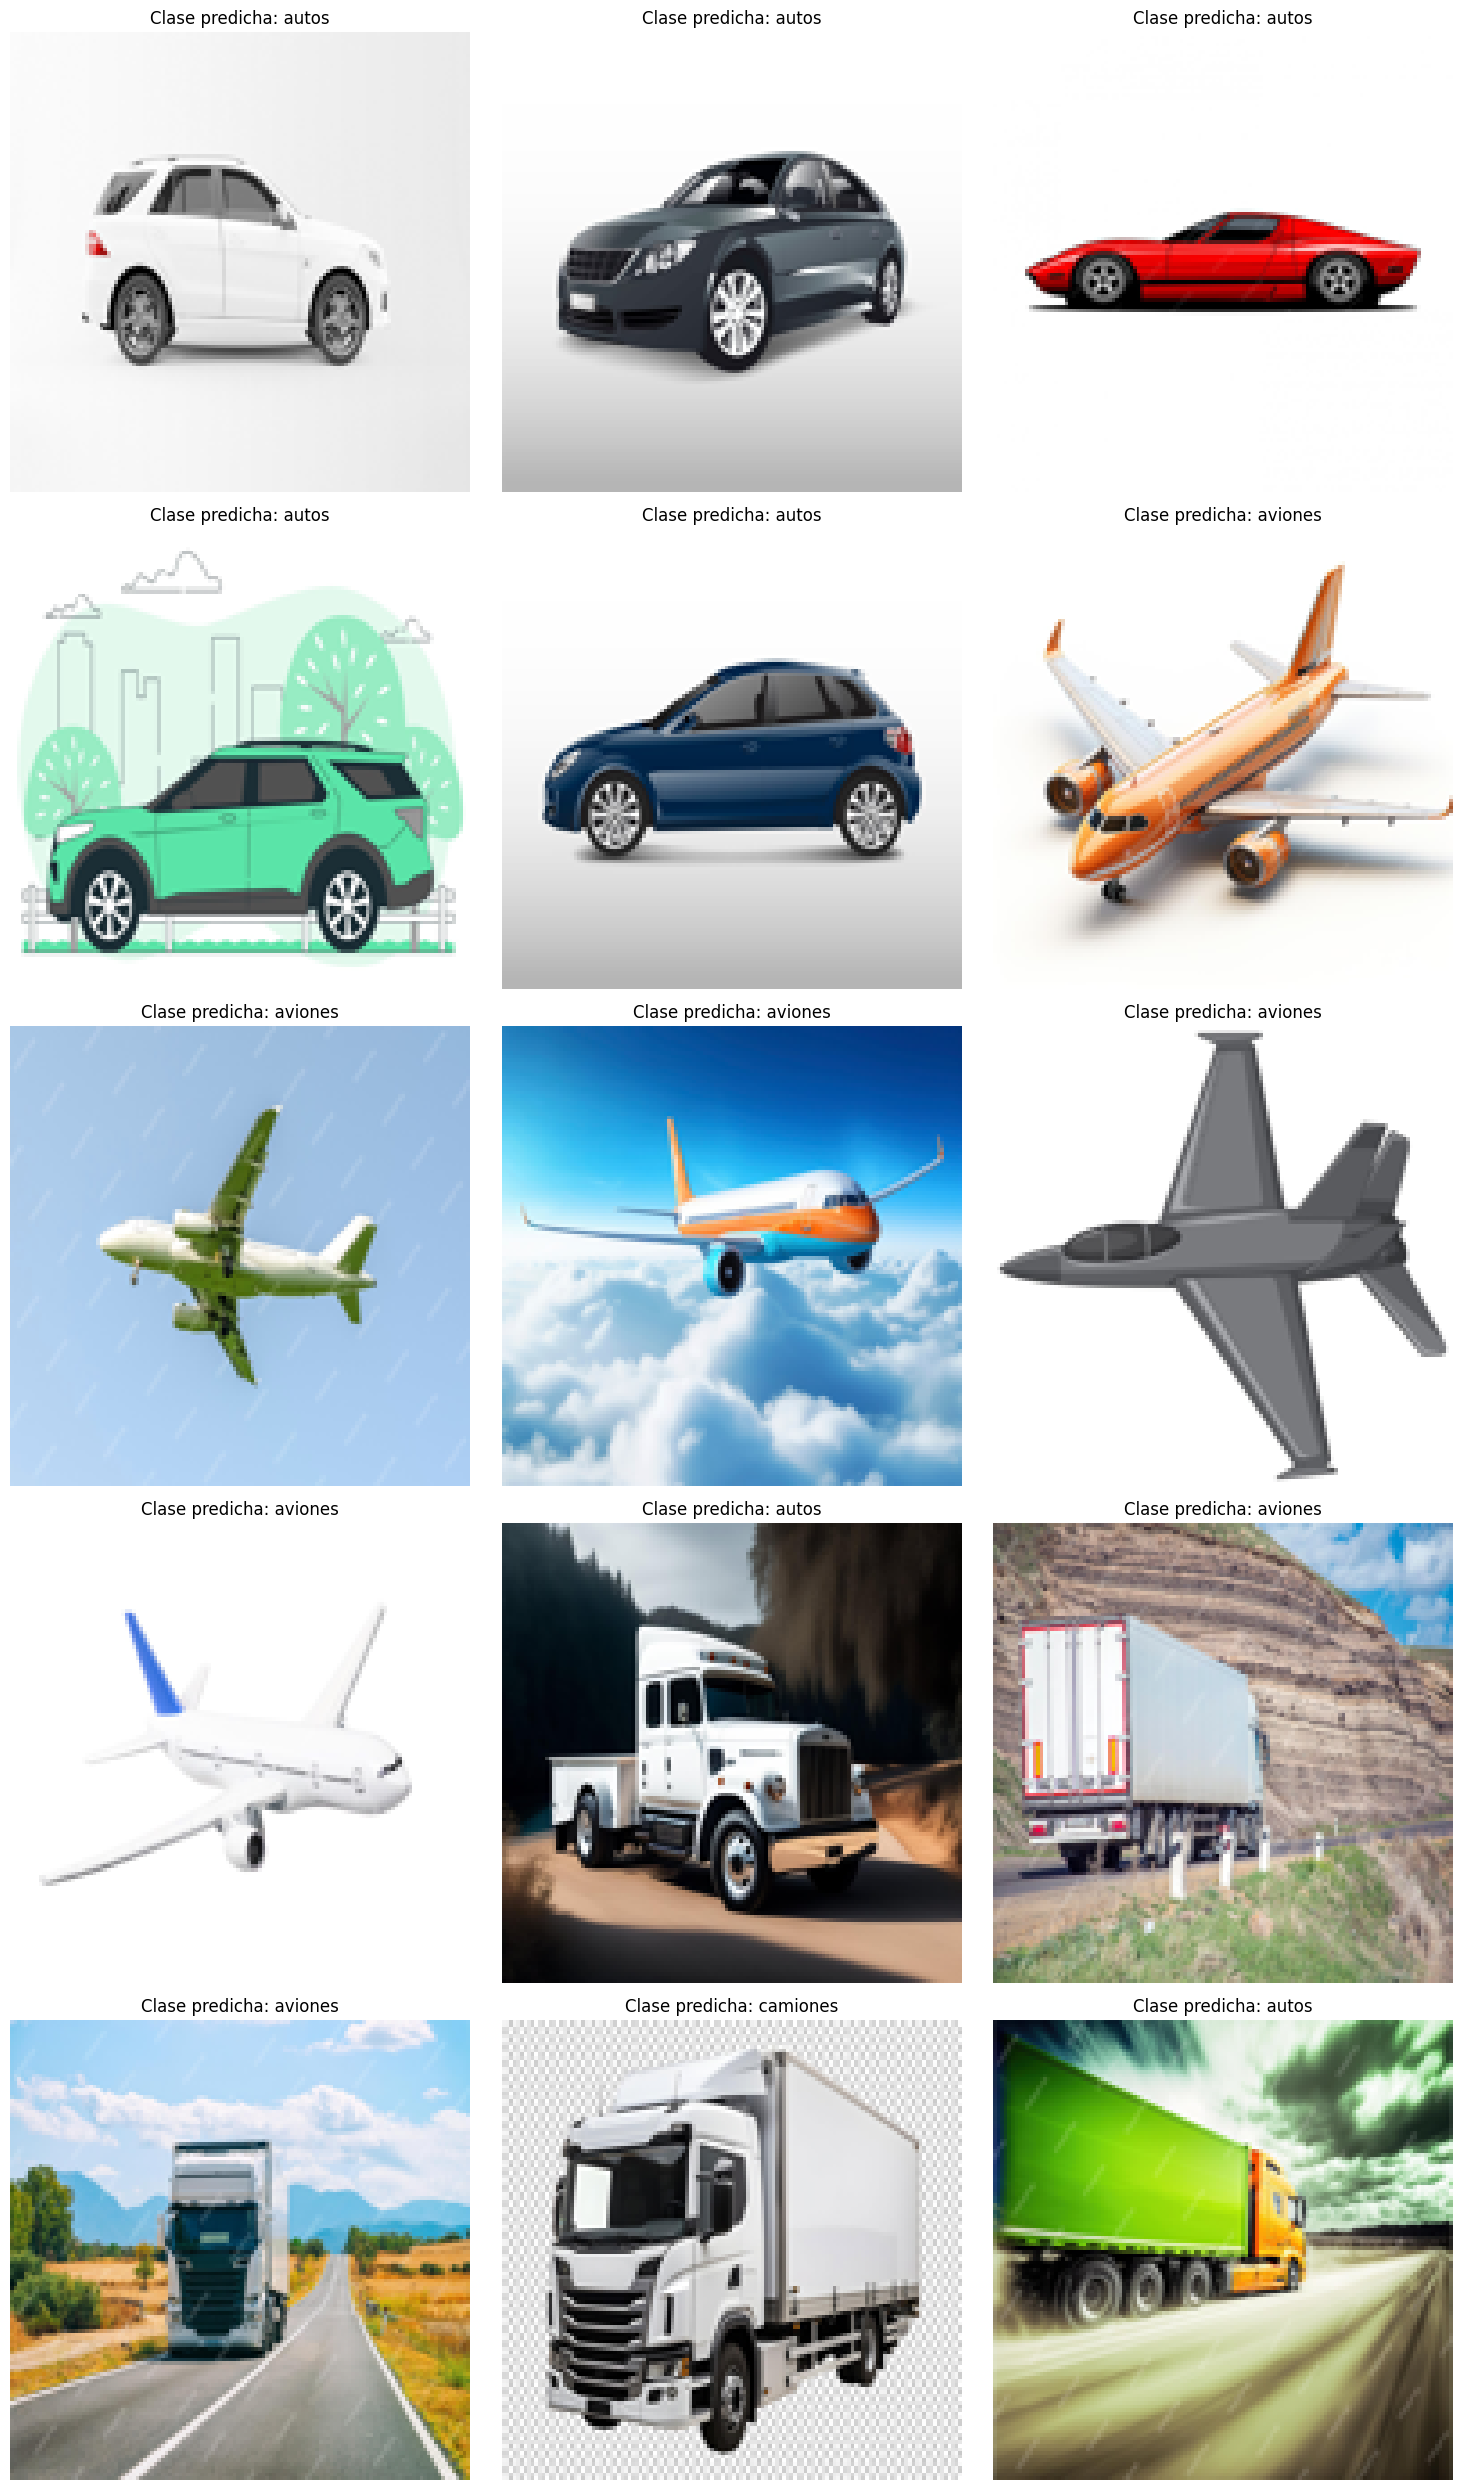

In [15]:
# Cargar el modelo guardado
model_path = r"C:\Users\Diego\Tarea UDD\Clase 3\modelo_ResNet50.h5"
model = load_model(model_path)

# Realizar predicciones
predictions = model.predict(x_train_data)

# Convertir predicciones a etiquetas
predicted_labels = np.argmax(predictions, axis=1)

# Crear un grid para visualizar las imágenes con predicciones
num_images = len(x_train_data)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols  # Calcular filas necesarias

plt.figure(figsize=(15, 5 * num_rows))

for i, (img, label) in enumerate(zip(x_train_data, predicted_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.title(f"Clase predicha: {label_encoder.inverse_transform([label])[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
